In [1]:
import pandas as pd
import numpy as np

#读取收盘价，个股权重，指数数据
close = pd.read_feather('close.txt').set_index('date')
weight = pd.read_feather('weight.txt')
index = pd.read_feather('000016.txt').set_index('date')
#计算每个交易日的收益率（收盘价已复权，可以直接计算）
ret = (close - close.shift(1)) / close
#历史平均收益率
mu_vec = ret.mean()
#历史收益率的协方差矩阵
varSigma = ret.cov()
#cholesky分解
A_cholesky = np.linalg.cholesky(np.array(varSigma))

In [2]:
def monte_carlo_simulate():
    # 生成50组标准正态随机变量，每组10个
    epsilon_m = []
    for i in range(50):
        epsilon_m.append(np.random.normal(loc=0.0, scale=1.0, size=10))
    epsilon_m = np.array(epsilon_m)

    # 分10天，每天50个随机变量，用于模拟个股收益率
    ret_sim = []
    for epsilon_vec in epsilon_m.T:
        #计算联合布朗运动方程向量形式，即前一部分公式（13）的右半部分
        ret_log_vec = mu_vec-0.5*A_cholesky*A_cholesky@(np.ones(50).T) + A_cholesky@epsilon_vec
        ret_sim.append(np.exp(ret_log_vec))
    ret_sim = pd.DataFrame(ret_sim)
    # 返回五十支股票的（收益率+1）矩阵
    return ret_sim

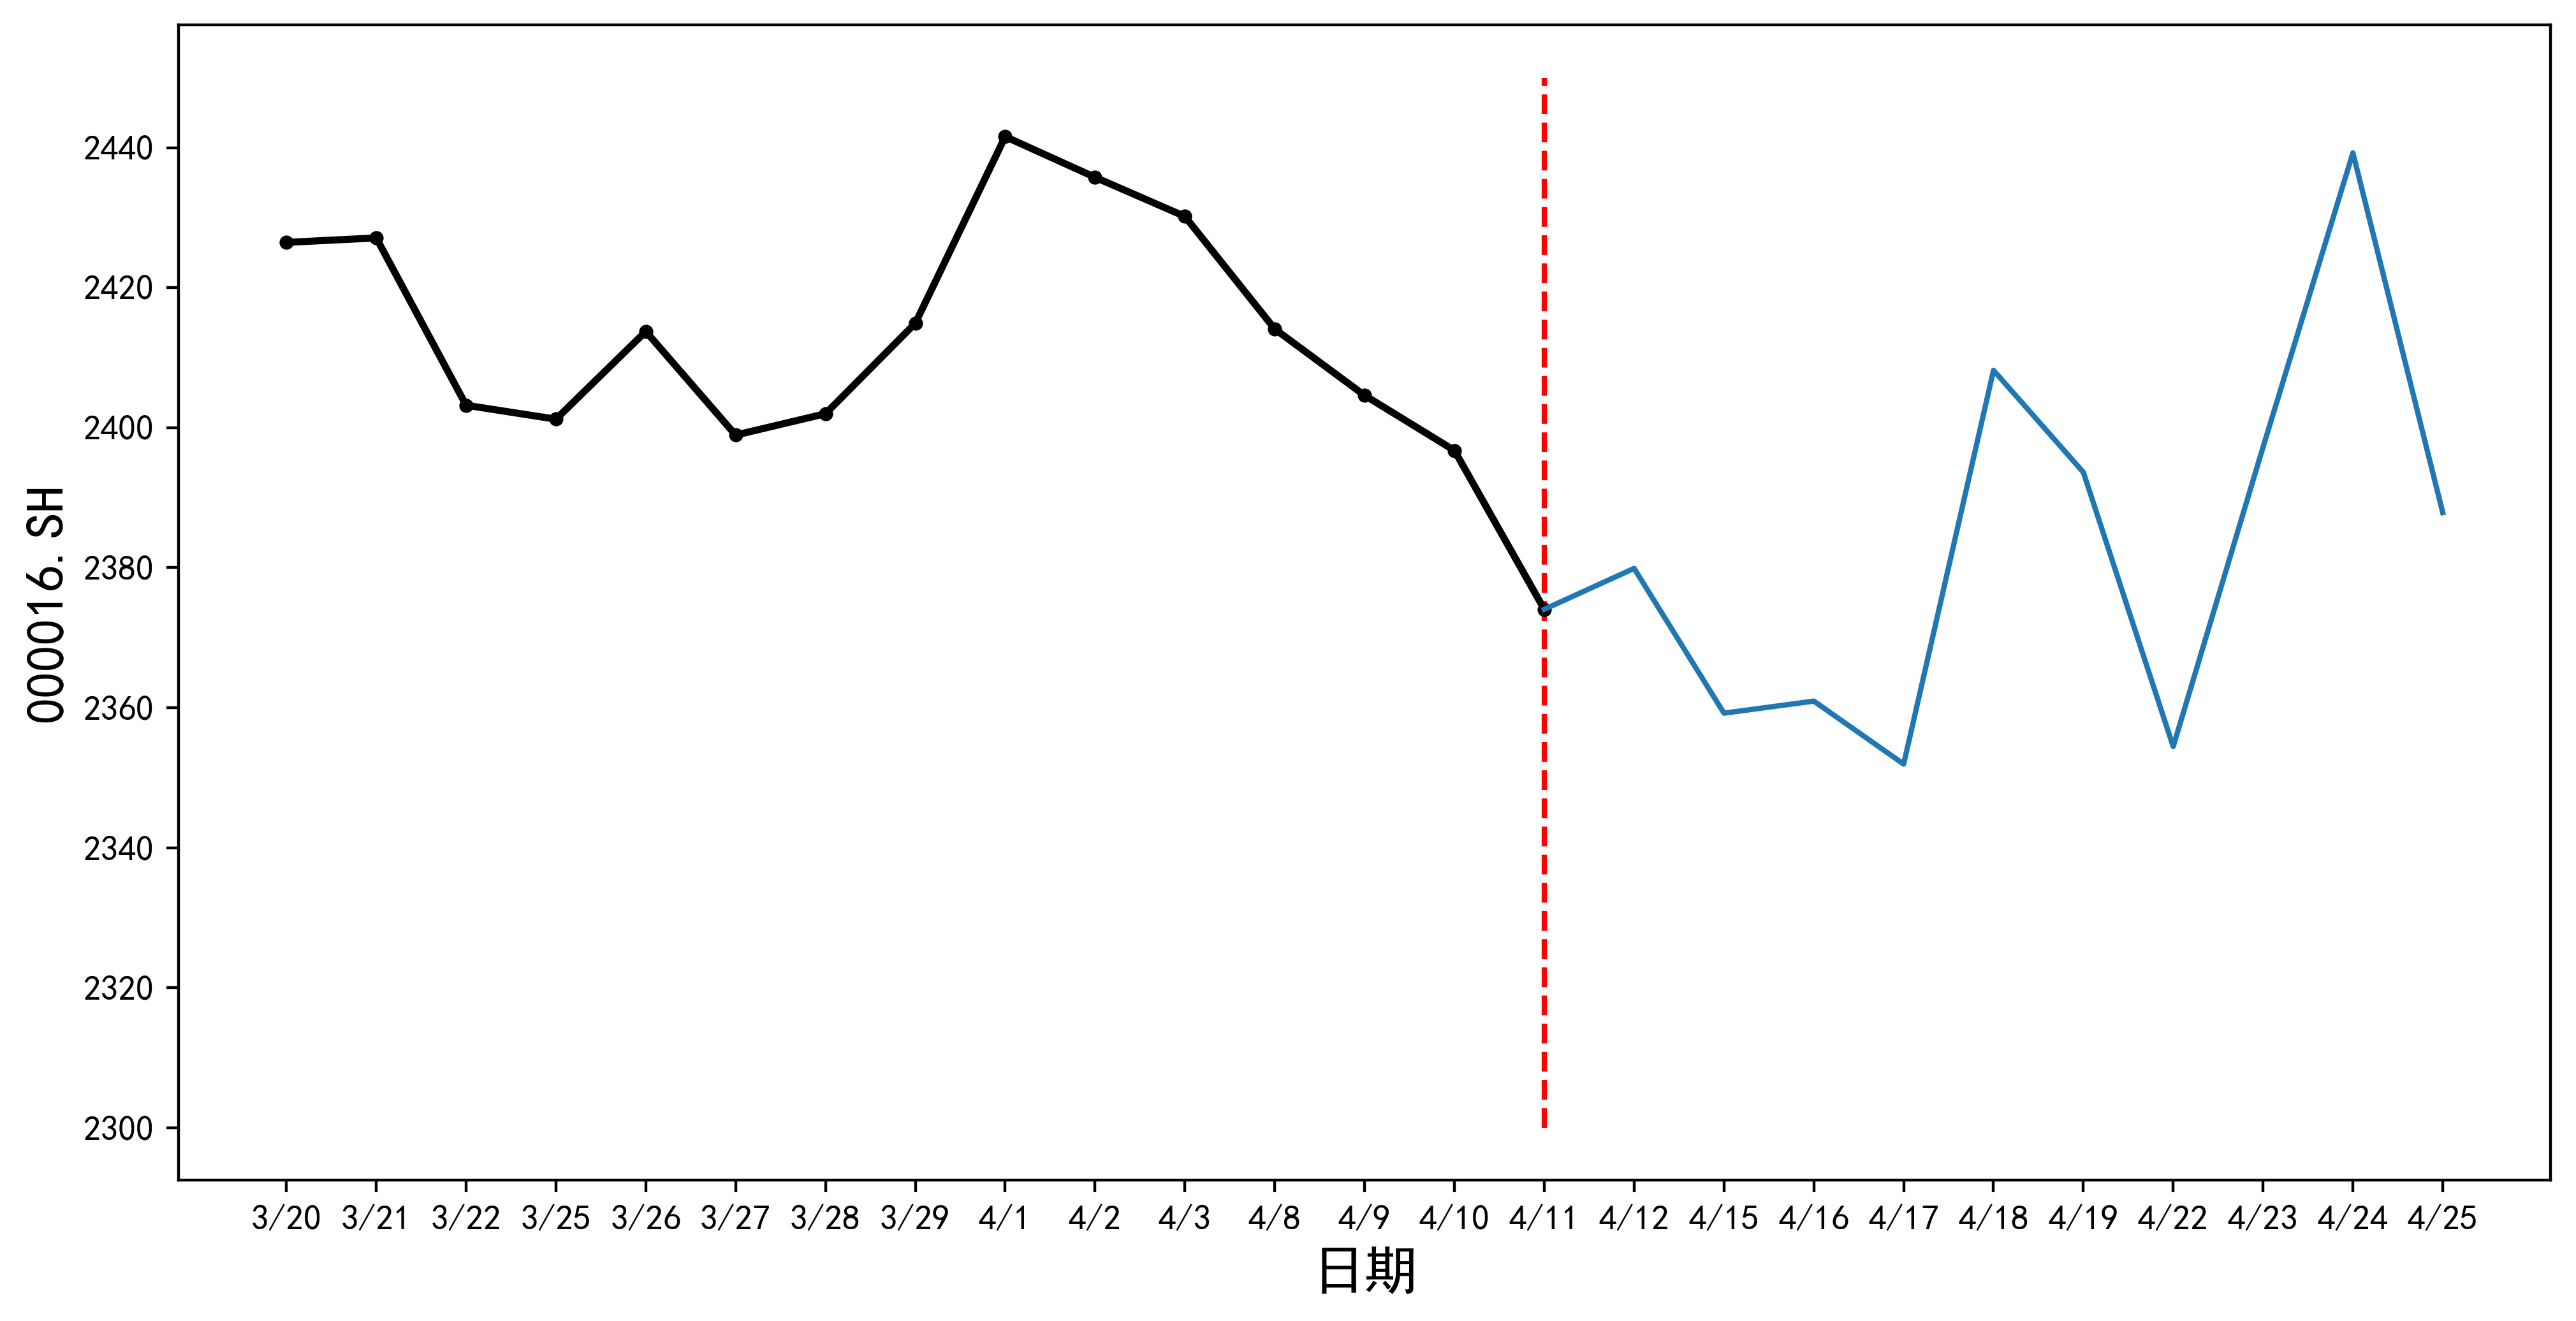

In [26]:
#导入绘图库并设置
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.figure(figsize=(12,6),dpi=400)
plt.xlabel('日期',fontsize=15)
plt.ylabel('000016.SH',fontsize=15)
#画历史数据
index_history = index.head(15)['close'].iloc[::-1]
index_history.index = [k[5:] for k in index_history.index]  
plt.plot(index_history,marker='.',label='历史数据',color='black',linewidth=2)
#画预测数据（这里30表示30组）
for i in range(1):
    ret_sim = monte_carlo_simulate()
    weight.index = weight['code'].astype(str)
    index_ret_sim = weight['weight']* ret_sim * 0.01
    index_sim = index_ret_sim.T.sum() * index['close'][0]
    index_sim.index = ['4/12','4/15','4/16','4/17','4/18','4/19','4/22','4/23','4/24','4/25']
    index_sim['4/11']=index['close'][0]
    index_sim = index_sim.sort_index()
    plt.plot(index_sim)
plt.vlines('4/11',2300,2450,colors='red',linestyles='dashed')